In [1]:
import bnpy
import numpy as np
import os

from matplotlib import pylab
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from hmmlearn.hmm import GaussianHMM
from bnpy import HModel
import time
from sklearn.utils import check_random_state
from importlib import reload

In [3]:
# # load data
#
# results_em = pickle.load(open(r'/Users/david/Documents/mastersCode/bnpy/bnpy/examples/08_mocap6/results_em.pkl', 'rb'))
# results_em_bnpy = pickle.load(open(r'/Users/david/Documents/mastersCode/bnpy/bnpy/examples/08_mocap6/results_em_bnpy.pkl', 'rb'))
# results_vi_finite = pickle.load(open(r'/Users/david/Documents/mastersCode/bnpy/bnpy/examples/08_mocap6/results_vi_finite.pkl', 'rb'))
# results_vi_inf = pickle.load(open(r'/Users/david/Documents/mastersCode/bnpy/bnpy/examples/08_mocap6/results_vi_infinite.pkl', 'rb'))

def get_GroupXData_from_list(features_list):
    features_concat = np.vstack(features_list)
    features_len = [0]
    n_doc = 0
    rolling_total = 0

    for i in range(len(features_list)):
        features_len.append(len(features_list[i]) + rolling_total)
        rolling_total += len(features_list[i])
        n_doc += 1

    features_len = np.array(features_len)

    return bnpy.data.GroupXData(X=features_concat, doc_range=features_len,
                                          nDocTotal=n_doc)

def get_hmm_learn_from_bnpy(some_model: HModel):

    obs_model = some_model.obsModel
    total_k = obs_model.K
    means = []
    sigmas = []
    for k in range(total_k):
        sigmas.append(np.diag(obs_model.get_covar_mat_for_comp(k)))
        means.append(obs_model.get_mean_for_comp(k))

    means = np.vstack(means)
    sigmas = np.vstack(sigmas)

    A = some_model.allocModel.get_trans_prob_matrix(),
    pi = some_model.allocModel.get_init_prob_vector(),

    # return A, pi,

    # creat hmm
    hmm_bnpy = GaussianHMM(n_components=len(pi[0]), covariance_type='diag', init_params='')
    hmm_bnpy.n_features = means.shape[1]
    hmm_bnpy.transmat_, hmm_bnpy.startprob_, hmm_bnpy.means_ = normalize_matrix(A[0]), normalize_matrix(pi[0]), means
    hmm_bnpy.covars_ = sigmas
    return hmm_bnpy

def normalize_matrix(matrix):
    matrix += 1e-40
    return matrix / np.sum(matrix, axis=(matrix.ndim - 1), keepdims=True)


# check list
 [1] EM HMM
 ll, criteria, time (complete), time (it)
 [2] Finite HMM VI
 ll, criteria, time (complete), eff components, elbo, time (it)
 [3] Infinite HMM VI
 ll, criteria, time (complete), eff components, elbo, time (it)

Results - max test ll
fin vi - 953
inf vi - 947


In [34]:
hmm_data = pickle.load(open(r'/Users/david/Documents/mastersCode/ubm/final/tests/get_features/humpback_cv_output_mfcc_avg.pkl', 'rb'))

In [47]:

def get_all_results(model_types, ns):
    n_inits = np.arange(0,1,1)
    sF = 1.0          # Set observation model prior so E[covariance] = identity
    ECovMat = 'eye'
    all_results = {}
    train_length = len(hmm_data['train_data'])
    cv_amt = 1 # train_length
    nlap = 150
    concentration_alpha = 10
    concentration_alpha_2 = 10
    for model_ind in range(len(model_types)):
        print('testing for model_type: ', model_types[model_ind])
        model_results = {}
        results_per_component = {}  # results per dimension
        start_outer = time.time()
        cv_len = 0
        for n in ns:
            print('collecting results for state count: ',n)

            cv_len = len(hmm_data['train_data'])
            curr_test = hmm_data['test_data']

            lls = []
            models = []
            elbos = []
            final_components = []
            it_times = []
            total_inits = 0

            for cv_index in range(cv_amt):
                # define t,v,t
                curr_train = hmm_data['train_data'][cv_index]
                curr_val = hmm_data['val_data'][cv_index]
                curr_train_GroupXData = get_GroupXData_from_list(curr_train)
                # train model
                for i in n_inits:
                    start_inner = time.time()
                    curr_hmm = None
                    if model_types[model_ind] == 'hmmlearn':
                        # fit model
                        curr_hmm = GaussianHMM(n_components=n, covariance_type='diag')
                        curr_hmm.fit(np.concatenate(curr_train))

                        # append details
                        ll = curr_hmm.score(np.concatenate(curr_val))
                        lls.append(ll)

                        models.append(curr_hmm)

                        elbos.append(0)

                        end_inner = time.time()
                        it_times.append(end_inner - start_inner)

                        total_inits +=1
                        n_zero_comps = np.sum(np.isclose(np.sum(curr_hmm.means_, axis=1), 0))
                        t_comps = curr_hmm.means_.shape[0]
                        final_components.append(t_comps - n_zero_comps)

                    elif model_types[model_ind] == 'em_bnpy':
                        try:
                            hmmdiag_trained_model, hmmdiag_info_dict = bnpy.run(
                            curr_train_GroupXData, 'FiniteHMM', 'DiagGauss', 'EM',
                            output_path='/tmp/mocap6/showcase-K=20-model=HDPHMM+DiagGauss-ECovMat=1*eye/',
                            nLap=nlap, nTask=1, nBatch=1, convergeThr=0.0001,
                            K=n, initname='randexamples')
                        except Exception as e:
                            print("An unexpected error occurred :( :", e)
                        else:
                            elbo = hmmdiag_info_dict['loss']
                            curr_hmm = get_hmm_learn_from_bnpy(hmmdiag_trained_model)
                            ll = curr_hmm.score(np.concatenate(curr_val))
                            lls.append(ll)
                            models.append(curr_hmm)
                            elbos.append(elbo)
                            end_inner = time.time()
                            it_times.append(end_inner - start_inner)
                            total_inits +=1
                            n_zero_comps = np.sum(np.isclose(np.sum(curr_hmm.means_, axis=1), 0))
                            t_comps = curr_hmm.means_.shape[0]
                            final_components.append(t_comps - n_zero_comps)

                    elif model_types[model_ind] == 'vi_fin_bnpy':
                        try:
                            hmmdiag_trained_model, hmmdiag_info_dict = bnpy.run(
                            curr_train_GroupXData, 'FiniteHMM', 'DiagGauss', 'memoVB',
                            output_path='/tmp/mocap6/showcase-K=20-model=HDPHMM+DiagGauss-ECovMat=1*eye/',
                            nLap=nlap, nTask=1, nBatch=1, convergeThr=0.0001, startAlpha=5,
                            transAlpha=concentration_alpha, hmmKappa=10, sF=sF, ECovMat=ECovMat,
                            K=n, initname='randexamples')
                        except Exception as e:
                            print("An unexpected error occurred:", e)
                        else:
                            elbo = hmmdiag_info_dict['loss']
                            curr_hmm = get_hmm_learn_from_bnpy(hmmdiag_trained_model)
                            ll = curr_hmm.score(np.concatenate(curr_val))
                            lls.append(ll)
                            models.append(curr_hmm)
                            elbos.append(elbo)
                            end_inner = time.time()
                            it_times.append(end_inner - start_inner)
                            total_inits +=1
                            n_zero_comps = np.sum(np.isclose(np.sum(curr_hmm.means_, axis=1), 0))
                            t_comps = curr_hmm.means_.shape[0]
                            final_components.append(t_comps - n_zero_comps)
                    elif model_types[model_ind] == 'vi_inf_bnpy':
                        try:
                            hmmdiag_trained_model, hmmdiag_info_dict = bnpy.run(
                            curr_train_GroupXData, 'HDPHMM', 'DiagGauss', 'memoVB',
                            output_path='/tmp/mocap6/showcase-K=20-model=HDPHMM+DiagGauss-ECovMat=1*eye/',
                            nLap=nlap, nTask=1, nBatch=1, convergeThr=0.0001, startAlpha=5,
                            transAlpha=concentration_alpha_2, gamma=concentration_alpha, hmmKappa=10, sF=sF, ECovMat=ECovMat,
                            K=n, initname='randexamples')
                        except Exception as e:
                            print("An unexpected error occurred:", e)
                        else:
                            elbo = hmmdiag_info_dict['loss']
                            curr_hmm = get_hmm_learn_from_bnpy(hmmdiag_trained_model)
                            ll = curr_hmm.score(np.concatenate(curr_val))
                            lls.append(ll)
                            models.append(curr_hmm)
                            elbos.append(elbo)
                            end_inner = time.time()
                            it_times.append(end_inner - start_inner)
                            total_inits +=1
                            n_zero_comps = np.sum(np.isclose(np.sum(curr_hmm.means_, axis=1), 0))
                            t_comps = curr_hmm.means_.shape[0]
                            final_components.append(t_comps - n_zero_comps)

            best_model = np.argmax(lls)
            average_score = np.mean(lls)
            results_per_component[n] = {
                'lls': lls,
                'elbos': elbos,
                'models': models,
                'time': it_times,
                'test': models[best_model].score(np.concatenate(curr_test)),
                'avg_val': average_score,
                'final_components': final_components,
                'its': total_inits
            }

        end_outer = time.time()
        model_results['total_time'] = end_outer - start_outer
        model_results['components'] = results_per_component
        model_results['total_its'] = cv_len * len(n_inits)
        model_results['component_list'] = ns
        all_results[model_types[model_ind]] = model_results
    return all_results

ns = [5,10,15,20,25] # ['5','10','15','20','25','30'] # state count
results = get_all_results(['hmmlearn','em_bnpy','vi_fin_bnpy','vi_inf_bnpy'], ns) # 'hmmlearn','em_bnpy',

# 'hmmlearn', 'em_bnpy', 'vi_fin_bnpy',
# data_temp = hmm_data['train_data'][0][0]
# print('loc: ', loc)

testing for model_type:  hmmlearn
collecting results for state count:  5
collecting results for state count:  10
collecting results for state count:  15
collecting results for state count:  20
collecting results for state count:  25
testing for model_type:  em_bnpy
collecting results for state count:  5
  --nBatch
Dataset Summary:
GroupXData
  size: 12 units (documents)
  dimension: 8
Allocation Model:  None
Obs. Data  Model:  Gaussian with diagonal covariance.
Obs. Data  Prior:  independent Gauss-Wishart prior on each dimension
  Wishart params 
    nu = 10  ...
  beta = [ 8  8]  ...
  Expectations
  E[  mean[k]] = 
  [ 0  0] ...
  E[ covar[k]] = 
  [[1. 0.]
   [0. 1.]] ...
Initialization:
  initname = randexamples
  K = 5 (number of clusters)
  seed = 1607680
  elapsed_time: 0.0 sec
Learn Alg: EM | task  1/1 | alg. seed: 1607680 | data order seed: 8541952
task_output_path: /tmp/mocap6/showcase-K=20-model=HDPHMM+DiagGauss-ECovMat=1*eye/1
        1/150 after      0 sec. |    345.2 MiB 

In [1]:

def train_model(model_type, train_data, val_data, n_components, **kwargs):

    model_trained = {}
    nlap = kwargs['nlap']
    concentration_alpha = kwargs['concentration_alpha']
    concentration_alpha_2 = kwargs['concentration_alpha_2']
    train_data_bnpy = get_GroupXData_from_list(train_data)
    start_time = time.time()

    if model_type == 'hmmlearn':
        curr_hmm = GaussianHMM(n_components=n_components, covariance_type='diag')
        curr_hmm.fit(np.concatenate(train_data))
        model_trained['model'] = curr_hmm
        model_trained['elbo'] = 0
    elif model_type == 'em_bnpy':
        hmmdiag_trained_model, hmmdiag_info_dict = bnpy.run(
        train_data_bnpy, 'FiniteHMM', 'DiagGauss', 'EM',
        output_path='/tmp/mocap6/showcase-K=20-model=HDPHMM+DiagGauss-ECovMat=1*eye/',
        nLap=nlap, nTask=1, nBatch=1, convergeThr=0.0001,
        K=n, initname='randexamples')
        model_trained['model'] = get_hmm_learn_from_bnpy(hmmdiag_trained_model)
        model_trained['bnpy_model'] = hmmdiag_trained_model
        model_trained['bnpy_hist'] = hmmdiag_info_dict
        model_trained['elbo'] = hmmdiag_info_dict['loss']
    elif model_type == 'vi_fin_bnpy':
        hmmdiag_trained_model, hmmdiag_info_dict = bnpy.run(
        train_data_bnpy, 'FiniteHMM', 'DiagGauss', 'memoVB',
        output_path='/tmp/mocap6/showcase-K=20-model=HDPHMM+DiagGauss-ECovMat=1*eye/',
        nLap=nlap, nTask=1, nBatch=1, convergeThr=0.0001, startAlpha=5,
        transAlpha=concentration_alpha, hmmKappa=10, sF=sF, ECovMat=ECovMat,
        K=n, initname='randexamples')
        model_trained['model'] = get_hmm_learn_from_bnpy(hmmdiag_trained_model)
        model_trained['bnpy_model'] = hmmdiag_trained_model
        model_trained['bnpy_hist'] = hmmdiag_info_dict
        model_trained['elbo'] = hmmdiag_info_dict['loss']
    elif model_type == 'vi_inf_bnpy':
        hmmdiag_trained_model, hmmdiag_info_dict = bnpy.run(
        train_data_bnpy, 'HDPHMM', 'DiagGauss', 'memoVB',
        output_path='/tmp/mocap6/showcase-K=20-model=HDPHMM+DiagGauss-ECovMat=1*eye/',
        nLap=nlap, nTask=1, nBatch=1, convergeThr=0.0001, startAlpha=5,
        transAlpha=concentration_alpha_2, gamma=concentration_alpha, hmmKappa=10, sF=sF, ECovMat=ECovMat,
        K=n, initname='randexamples')
        model_trained['model'] = get_hmm_learn_from_bnpy(hmmdiag_trained_model)
        model_trained['bnpy_model'] = hmmdiag_trained_model
        model_trained['bnpy_hist'] = hmmdiag_info_dict
        model_trained['elbo'] = hmmdiag_info_dict['loss']

    # N comps
    model_trained['val'] = model_trained['model'].score(np.concatenate(val_data))
    n_zero_comps = np.sum(np.isclose(np.sum(model_trained['model'].means_, axis=1), 0))
    model_trained['n_comps'] = model_trained['model'].means_.shape[0]
    model_trained['n_final_comps'] = model_trained['n_comps'] - n_zero_comps
    model_trained['time'] = time.time() - start_time

    return model_trained


SyntaxError: invalid syntax (1504359306.py, line 3)

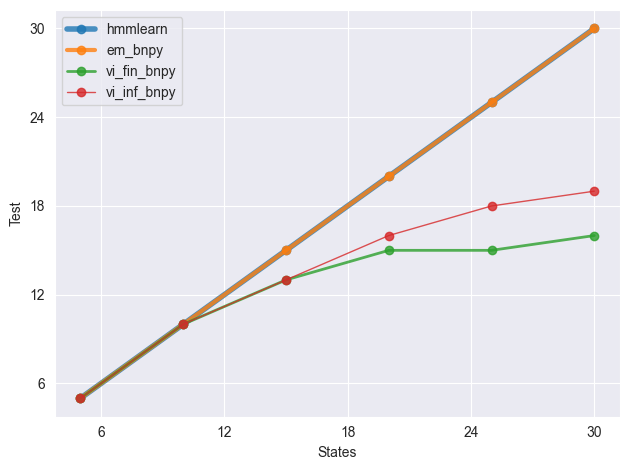

In [46]:
# ns = [20,25,30,35,40]
fig, ax = plt.subplots()
fig.tight_layout()
line_width = 5
for key in results:
    line_width -= 1
    # if key != 'em_bnpy':
    components_results = results[key]['components']
    avg_times = [np.mean(components_results[some_key]['time']) for some_key in components_results]
    std_times = [np.std(components_results[some_key]['time']) for some_key in components_results]
    test = [components_results[some_key]['test'] for some_key in components_results]
    val = [components_results[some_key]['avg_val'] for some_key in components_results]

    elbos = [np.nanmin(components_results[some_key]['elbos']) for some_key in components_results]
    final_components = [np.min(components_results[some_key]['final_components']) for some_key in components_results]

    # ax.plot(ns, test, label=key, marker='o')
    # ax.plot(ns, val, label=key, marker='o')
    ax.plot(ns, final_components, label=key, marker='o', linewidth=line_width, alpha=0.8)

    # if not np.any(np.array(elbos) == 0):
    #     ax.plot(ns, elbos, label=key, marker='o', )
    # # ax2.set_ylim(0,15)
    # # ax2.set_yticks(np.arange(0,15,1))
    #
    # ax3 = ax.twinx()
    # ax3.plot(ns, elbo, label='Elbo', marker='o', color='green')
    # ax3.set_ylabel("Elbo")
    # ax3.spines['right'].set_position(('outward', 60))

ax.set_ylabel("Test")
# ax2.set_ylabel("Gradient")
# plt.title('HMM EM Validate/Test')
plt.xlabel('States')
# plt.ylabel('Score')
plt.legend()
fig.tight_layout()
plt.show()


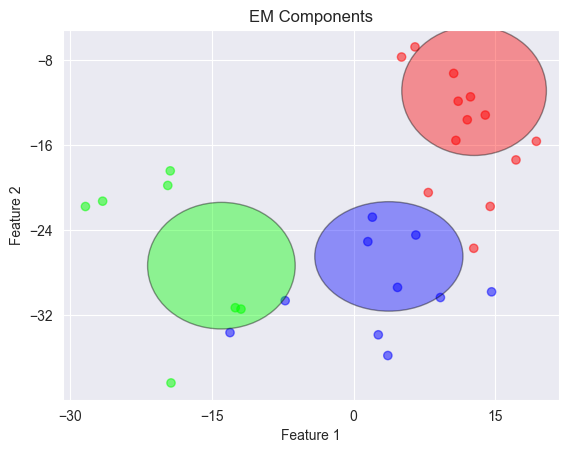

score:  -1336.7160666020807


In [33]:
from bnpy import plot_hmm
reload(plot_hmm)
curr_test = hmm_data['test_data']
curr_test_concat = np.concatenate(hmm_data['test_data'])
curr_test_0 = curr_test[0]
hmm_temp = results['vi_fin_bnpy']['components'][10]['models'][0] #,hmmlearn 'em_bnpy','vi_fin_bnpy','vi_inf_bnpy']
plot_hmm.plot_hmm_data(curr_test_0, hmm_temp.predict(curr_test_0), hmm_temp.n_components, hmm_temp.means_, hmm_temp.covars_, feature_a=5, feature_b=4, legend=False, title='EM Components')
print('score: ', hmm_temp.score(curr_test_0))

In [4]:
# run em and get aic / bic and cross-validation likelihood
curr_test = hmm_data['test_data']
curr_test_concat = np.concatenate(hmm_data['test_data'])
# ns = np.arange(2,40,1)
# n_inits = np.arange(0,10,1)
ns = np.arange(2,25,1) #np.arange(2,30,1)
n_inits = np.arange(0,1,1)

In [5]:
start_outer = time.time()
cv_index = 0
# np.random.seed(20)
all_lls = {}
results_em = {}
results_per_component = {}
for n in ns:
    print('calculating for n: ', n)
    start_inner = time.time()
    total_inits = 0
    lls = []
    models = []
    aic = []
    bic = []
    for cv_index in range(len(hmm_data['train_data'])):
        curr_train = hmm_data['train_data'][cv_index]
        curr_train_concat = np.concatenate(hmm_data['train_data'][cv_index])
        curr_train_lens = [len(train) for train in curr_train]
        curr_val = hmm_data['val_data'][cv_index]
        curr_val_concat = np.concatenate(hmm_data['val_data'][cv_index])
        curr_val_lens = [len(train) for train in curr_val]

        current_best = CurrentBest()
        for i in n_inits:
            total_inits += 1
            curr_hmm = GaussianHMM(n_components=n, covariance_type='diag') #,random_state=20)
            curr_hmm.fit(curr_train_concat,curr_train_lens)
            ll = curr_hmm.score(curr_val_concat, curr_val_lens)
            lls.append(ll)
            models.append(curr_hmm)
            if not current_best.updated or ll > current_best.ll:
                # print('no comp: ', n,' || n_init: ', i,' || ll: ',ll)
                current_best.update(ll=ll,hmmLearn=curr_hmm)
            aic.append(curr_hmm.aic(curr_train_concat, curr_train_lens))
            bic.append(curr_hmm.bic(curr_train_concat, curr_train_lens))
    best_model = np.argmax(lls)
    average_score = np.mean(lls)
    end_inner = time.time()
    results_per_component[n] = {
        'lls': lls,
        'models': models,
        'test': models[best_model].score(np.concatenate(curr_test),[len(train) for train in curr_test]),
        'avg_val': average_score,
        'bic': np.mean(bic),
        'aic': np.mean(aic),
        'time': (end_inner - start_inner)
    }

end_outer = time.time()
results_em['total_time'] = end_outer - start_outer
results_em['components'] = results_per_component
results_em['total_its'] = len(hmm_data['train_data']) * len(n_inits)
results_em['component_list'] = ns
# cv_results_em.total_time = end_outer - start_outer
    # aic_em.append(best_model.aic(np.concatenate(curr_test)))
    # bic_em.append(best_model.bic(np.concatenate(curr_test)))
    # lls_em.append(best_model.score(np.concatenate(curr_test)))
    # lls_em_train.append(best_model.score(np.concatenate(curr_test)))

calculating for n:  2
calculating for n:  3
calculating for n:  4
calculating for n:  5
calculating for n:  6
calculating for n:  7
calculating for n:  8
calculating for n:  9
calculating for n:  10
calculating for n:  11
calculating for n:  12
calculating for n:  13
calculating for n:  14
calculating for n:  15
calculating for n:  16
calculating for n:  17
calculating for n:  18
calculating for n:  19
calculating for n:  20
calculating for n:  21
calculating for n:  22
calculating for n:  23
calculating for n:  24


In [248]:
# print("Writing to pickle file: " + BASENAME + ".pkl")
output = open('results_em_hb' + ".pkl", "wb")
pickle.dump(results_em, output)
output.close()

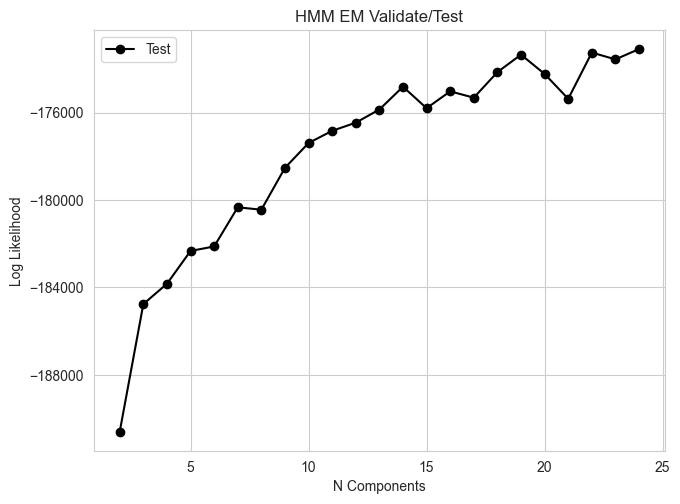

In [6]:
components_results = results_em['components']
fig, ax = plt.subplots()
fig.tight_layout()
avg_val_ll = [components_results[some_key]['avg_val'] for some_key in components_results]
test_ll = [components_results[some_key]['test'] for some_key in components_results]

# ax.plot(ns, avg_val_ll, color='blue', label='Val', marker='o')
ax.plot(ns, test_ll, color='black', label='Test', marker='o')

# ax2 = ax.twinx()
# ax2.plot(ns, np.gradient(avg_val_ll), color='darkblue', label='test', marker='o')

ax.set_ylabel("Log Likelihood")
# ax2.set_ylabel("Gradient")
plt.title('HMM EM Validate/Test')
plt.xlabel('N Components')
# plt.ylabel('Score')
plt.legend()
plt.show()


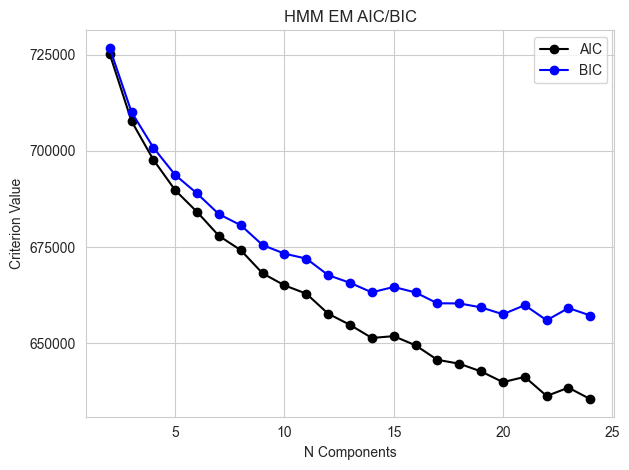

In [7]:
fig, ax = plt.subplots()

bic = [components_results[some_key]['bic'] for some_key in components_results]
aic = [components_results[some_key]['aic'] for some_key in components_results]

ax.plot(ns, aic, color='black', label='AIC', marker='o')
ax.plot(ns, bic, color='blue', label='BIC', marker='o')

# ax2 = ax.twinx()
# ax2.plot(ns, np.gradient(avg_val_ll), color='darkblue', label='test', marker='o')

ax.set_ylabel("log likelihood")
# ax2.set_ylabel("Gradient")
plt.title('HMM EM AIC/BIC')
plt.xlabel('N Components')
plt.ylabel('Criterion Value')
plt.legend()
fig.tight_layout()
plt.show()


In [8]:
# plt.errorbar(ns, np.gradient(bic), label='BIC')
# plt.errorbar(ns, np.gradient(aic), label='AIC')
# plt.title("Gradient of BIC Scores", fontsize=20)
# # plt.xticks(ns)
# plt.xlabel("N. of clusters")
# plt.ylabel("grad(BIC)")
# plt.legend()
def get_GroupXData_from_list(features_list):
    features_concat = np.vstack(features_list)
    features_len = [0]
    n_doc = 0
    rolling_total = 0

    for i in range(len(features_list)):
        features_len.append(len(features_list[i]) + rolling_total)
        rolling_total += len(features_list[i])
        n_doc += 1

    features_len = np.array(features_len)

    return bnpy.data.GroupXData(X=features_concat, doc_range=features_len,
                                          nDocTotal=n_doc)

def get_hmm_learn_from_bnpy(some_model: HModel):

    obs_model = some_model.obsModel
    total_k = obs_model.K
    means = []
    sigmas = []
    for k in range(total_k):
        sigmas.append(np.diag(obs_model.get_covar_mat_for_comp(k)))
        means.append(obs_model.get_mean_for_comp(k))

    means = np.vstack(means)
    sigmas = np.vstack(sigmas)

    A = some_model.allocModel.get_trans_prob_matrix(),
    pi = some_model.allocModel.get_init_prob_vector(),

    # return A, pi,

    # creat hmm
    hmm_bnpy = GaussianHMM(n_components=len(pi[0]), covariance_type='diag', init_params='')
    hmm_bnpy.n_features = means.shape[1]
    hmm_bnpy.transmat_, hmm_bnpy.startprob_, hmm_bnpy.means_ = normalize_matrix(A[0]), normalize_matrix(pi[0]), means
    hmm_bnpy.covars_ = sigmas
    return hmm_bnpy

def normalize_matrix(matrix):
    matrix += 1e-40
    return matrix / np.sum(matrix, axis=(matrix.ndim - 1), keepdims=True)



In [11]:
start_outer = time.time()
results_em_bnpy = {}
results_per_component = {}
n_inits_v2 = np.arange(0,2,1)
ns = np.arange(2,30,1)

for n in ns:

    print('calculating for n: ', n)
    start_inner = time.time()
    total_inits = 0
    lls = []
    models = []
    aic = []
    bic = []
    models_bnpy = []
    elbos = []
    final_components = []

    for cv_index in range(len(hmm_data['train_data'])):
        curr_train = hmm_data['train_data'][cv_index]
        curr_train_GroupXData = get_GroupXData_from_list(curr_train)
        curr_val = hmm_data['val_data'][cv_index]

        for i in n_inits_v2:
            total_inits += 1

            # train and test
            hmmdiag_trained_model, hmmdiag_info_dict = bnpy.run(
            curr_train_GroupXData, 'FiniteHMM', 'DiagGauss', 'EM',
            output_path='/tmp/mocap6/showcase-K=20-model=HDPHMM+DiagGauss-ECovMat=1*eye/',
            nLap=100, nTask=1, nBatch=1, convergeThr=0.0001,
            K=n, initname='randexamples')
            elbo = hmmdiag_info_dict['loss']
            curr_hmm = get_hmm_learn_from_bnpy(hmmdiag_trained_model)
            ll = curr_hmm.score(np.concatenate(curr_val))

            # append
            lls.append(ll)
            models.append(curr_hmm)
            aic.append(curr_hmm.aic(np.concatenate(curr_train + curr_val)))
            bic.append(curr_hmm.bic(np.concatenate(curr_train + curr_val)))
            models_bnpy.append([hmmdiag_trained_model, hmmdiag_info_dict])
            elbos.append(elbo)

    best_model = np.argmax(lls)
    average_score = np.mean(lls)
    end_inner = time.time()
    results_per_component[n] = {
        'lls': lls,
        'models': models,
        'bic': np.mean(bic),
        'aic': np.mean(aic),
        'models_bnpy': models_bnpy,
        'time': (end_inner - start_inner),
        'test': models[best_model].score(np.concatenate(curr_test)),
        'avg_val': average_score,
        'elbo': np.mean(elbos),
    }

end_outer = time.time()
results_em_bnpy['total_time'] = end_outer - start_outer
results_em_bnpy['components'] = results_per_component
results_em_bnpy['total_its'] = len(hmm_data['train_data']) * len(n_inits_v2)
results_em_bnpy['component_list'] = ns


calculating for n:  2
  --nBatch
Dataset Summary:
GroupXData
  size: 12 units (documents)
  dimension: 65
Allocation Model:  None
Obs. Data  Model:  Gaussian with diagonal covariance.
Obs. Data  Prior:  independent Gauss-Wishart prior on each dimension
  Wishart params 
    nu = 67  ...
  beta = [ 65  65]  ...
  Expectations
  E[  mean[k]] = 
  [ 0  0] ...
  E[ covar[k]] = 
  [[1. 0.]
   [0. 1.]] ...
Initialization:
  initname = randexamples
  K = 2 (number of clusters)
  seed = 1607680
  elapsed_time: 0.0 sec
Learn Alg: EM | task  1/1 | alg. seed: 1607680 | data order seed: 8541952
task_output_path: /tmp/mocap6/showcase-K=20-model=HDPHMM+DiagGauss-ECovMat=1*eye/1
        1/100 after      0 sec. |    409.5 MiB | K    2 | loss  4.073633262e+08 |  
        2/100 after      0 sec. |    409.5 MiB | K    2 | loss  2.121978823e+00 | Ndiff  264.596 
        3/100 after      0 sec. |    409.5 MiB | K    2 | loss  2.103924989e+00 | Ndiff   85.880 
        4/100 after      0 sec. |    409.5 MiB 

In [9]:
output = open('results_em_bnpy_hb' + ".pkl", "wb")
pickle.dump(results_em_bnpy, output)
output.close()

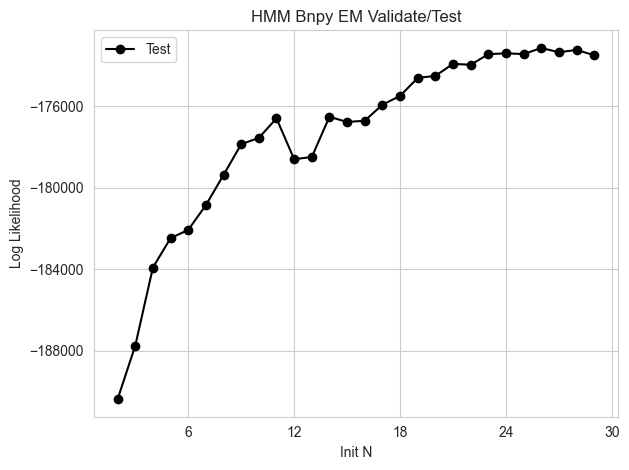

In [12]:
components_results = results_em_bnpy['components']
color1, color2, color3 = plt.cm.viridis([0, .5, .9])

avg_val_ll = [components_results[some_key]['avg_val'] for some_key in components_results]
test_ll = [components_results[some_key]['test'] for some_key in components_results]
# final_components = [components_results[some_key]['final_components_mean'] for some_key in components_results]
elbo = [components_results[some_key]['elbo'] for some_key in components_results]

fig, ax = plt.subplots()

# ax.plot(ns, avg_val_ll, color='blue', label='Val', marker='o')
ax.plot(ns, test_ll, color='black', label='Test', marker='o')

# ax2 = ax.twinx()
# ax2.plot(ns, final_components, color='orange', label='Final N', marker='o')
# ax2.set_ylim(0,15)
# ax2.set_yticks(np.arange(0,15,1))

# ax3 = ax.twinx()
# ax3.plot(ns, elbo, label='Loss', marker='o', color='green')
# ax3.set_ylabel("Loss")
# ax3.spines['right'].set_position(('outward', 60))
# ax3.set_ylim(-0.1,0.15)

ax.legend(handles=ax.lines) # + ax3.lines)
ax.set_title("HMM Bnpy EM Validate/Test")
ax.set_ylabel("Log Likelihood")
# ax2.set_ylabel("Final N")
ax.set_xlabel("Init N")
all_axes = fig.get_axes()
for axis in all_axes:
    legend = axis.get_legend()
    if legend is not None:
        legend.remove()
        all_axes[-1].add_artist(legend)
fig.tight_layout()
plt.show()


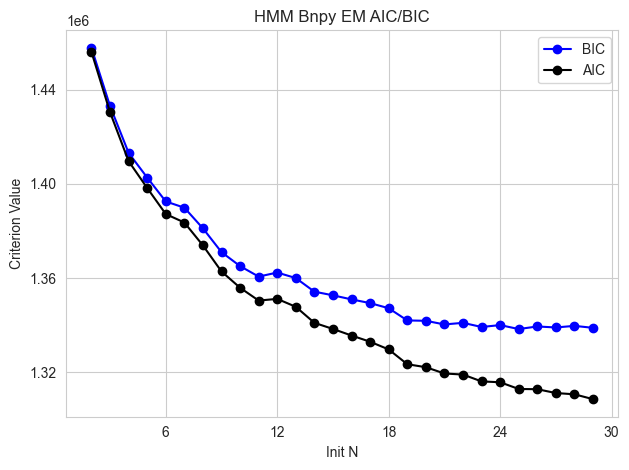

In [13]:
components_results = results_em_bnpy['components']
color1, color2, color3 = plt.cm.viridis([0, .5, .9])

bic = [components_results[some_key]['bic'] for some_key in components_results]
aic = [components_results[some_key]['aic'] for some_key in components_results]
# final_components = [components_results[some_key]['final_components_mean'] for some_key in components_results]
# elbo = [components_results[some_key]['elbo'] for some_key in components_results]

fig, ax = plt.subplots()

ax.plot(ns, bic, color='blue', label='BIC', marker='o')
ax.plot(ns, aic, color='black', label='AIC', marker='o')

# ax2 = ax.twinx()
# ax2.plot(ns, final_components, color='orange', label='Final N', marker='o')
# ax2.set_ylim(0,15)
# ax2.set_yticks(np.arange(0,15,1))

# ax3 = ax.twinx()
# ax3.plot(ns, elbo, label='Loss', marker='o', color='green')
# ax3.set_ylabel("Loss")
# ax3.spines['right'].set_position(('outward', 60))
# ax3.set_ylim(-0.1,0.15)

ax.legend(handles=ax.lines)
ax.set_title("HMM Bnpy EM AIC/BIC")
ax.set_ylabel("Criterion Value")
ax.set_xlabel("Init N")
all_axes = fig.get_axes()
for axis in all_axes:
    legend = axis.get_legend()
    if legend is not None:
        legend.remove()
        all_axes[-1].add_artist(legend)
fig.tight_layout()
plt.show()


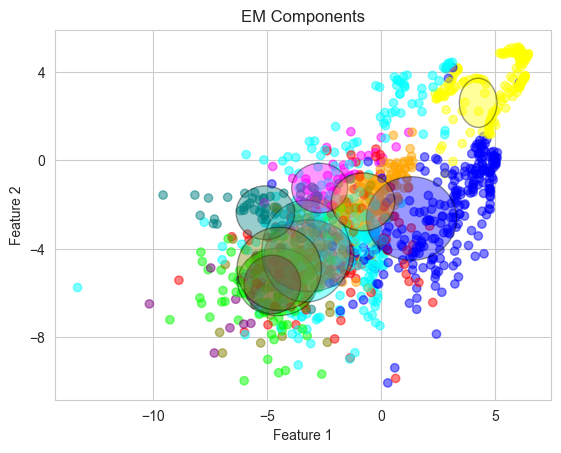

score:  -178115.04512037052


In [20]:
from bnpy import plot_hmm
reload(plot_hmm)
hmm_temp = results_em_bnpy['components'][11]['models'][0]
plot_hmm.plot_hmm_data(curr_test_concat, hmm_temp.predict(curr_test_concat), hmm_temp.n_components, hmm_temp.means_, hmm_temp.covars_, feature_a=14, feature_b=15, legend=False, title='EM Components')
print('score: ', hmm_temp.score(np.concatenate(curr_test)))

In [19]:
K = 20            # Number of clusters/states
transAlpha = 10  # trans-level Dirichlet concentration parameter
startAlpha = 2
sF = 1.0          # Set observation model prior so E[covariance] = identity
ECovMat = 'eye'

start_outer = time.time()
results_vi_finite = {}
results_per_component = {}

n_inits_v2 = np.arange(0,2,1)
ns = np.arange(2,30,1)

for n in ns:

    print('calculating for n: ', n)
    start_inner = time.time()
    total_inits = 0
    lls = []
    models = []
    aic = []
    bic = []
    models_bnpy = []
    elbos = []
    final_components = []

    for cv_index in range(len(hmm_data['train_data'])):
        curr_train = hmm_data['train_data'][cv_index]
        curr_train_GroupXData = get_GroupXData_from_list(curr_train)
        curr_val = hmm_data['val_data'][cv_index]

        for i in n_inits_v2:
            total_inits += 1

            # train and test
            hmmdiag_trained_model, hmmdiag_info_dict = bnpy.run(
            curr_train_GroupXData, 'FiniteHMM', 'DiagGauss', 'memoVB',
            output_path='/tmp/mocap6/showcase-K=20-model=HDPHMM+DiagGauss-ECovMat=1*eye/',
            nLap=100, nTask=1, nBatch=1, convergeThr=0.0001, startAlpha=startAlpha,
            transAlpha=transAlpha, hmmKappa=10, sF=sF, ECovMat=ECovMat,
            K=n, initname='randexamples')
            elbo = hmmdiag_info_dict['loss']
            curr_hmm = get_hmm_learn_from_bnpy(hmmdiag_trained_model)
            ll = curr_hmm.score(np.concatenate(curr_val))

            # append
            lls.append(ll)
            models.append(curr_hmm)
            aic.append(curr_hmm.aic(np.concatenate(curr_train + curr_val)))
            bic.append(curr_hmm.bic(np.concatenate(curr_train + curr_val)))
            models_bnpy.append([hmmdiag_trained_model, hmmdiag_info_dict])
            elbos.append(elbo)

            # final components from A matrix
            n_zero_comps = np.sum(np.isclose(np.sum(curr_hmm.means_, axis=1), 0))
            t_comps = curr_hmm.means_.shape[0]
            final_components.append(t_comps - n_zero_comps)

    best_model = np.argmax(lls)
    average_score = np.mean(lls)
    end_inner = time.time()
    results_per_component[n] = {
        'lls': lls,
        'models': models,
        'bic': np.mean(bic),
        'aic': np.mean(aic),
        'models_bnpy': models_bnpy,
        'time': (end_inner - start_inner),
        'test': models[best_model].score(np.concatenate(curr_test)),
        'avg_val': average_score,
        'elbo': np.mean(elbos),
        'final_components': final_components,
        'final_components_mean': np.mean(final_components)
    }

end_outer = time.time()
results_vi_finite['total_time'] = end_outer - start_outer
results_vi_finite['components'] = results_per_component
results_vi_finite['total_its'] = len(hmm_data['train_data']) * len(n_inits_v2)
results_vi_finite['component_list'] = ns


calculating for n:  2
Dataset Summary:
GroupXData
  total size: 12 units
  batch size: 12 units
  num. batches: 1
Allocation Model:  None
Obs. Data  Model:  Gaussian with diagonal covariance.
Obs. Data  Prior:  independent Gauss-Wishart prior on each dimension
  Wishart params 
    nu = 67  ...
  beta = [ 65  65]  ...
  Expectations
  E[  mean[k]] = 
  [ 0  0] ...
  E[ covar[k]] = 
  [[1. 0.]
   [0. 1.]] ...
Initialization:
  initname = randexamples
  K = 2 (number of clusters)
  seed = 1607680
  elapsed_time: 0.0 sec
Learn Alg: memoVB | task  1/1 | alg. seed: 1607680 | data order seed: 8541952
task_output_path: /tmp/mocap6/showcase-K=20-model=HDPHMM+DiagGauss-ECovMat=1*eye/1
    1.000/100 after      0 sec. |   1967.1 MiB | K    2 | loss  2.160036741e+00 |  
    2.000/100 after      0 sec. |   1967.1 MiB | K    2 | loss  2.133651870e+00 | Ndiff  250.715 
    3.000/100 after      0 sec. |   1967.1 MiB | K    2 | loss  2.122912575e+00 | Ndiff   89.552 
    4.000/100 after      0 sec. |  

In [48]:
# print("Writing to pickle file: " + BASENAME + ".pkl")
output = open('results_vi_finite_hb' + ".pkl", "wb")
pickle.dump(results_vi_finite, output)
output.close()

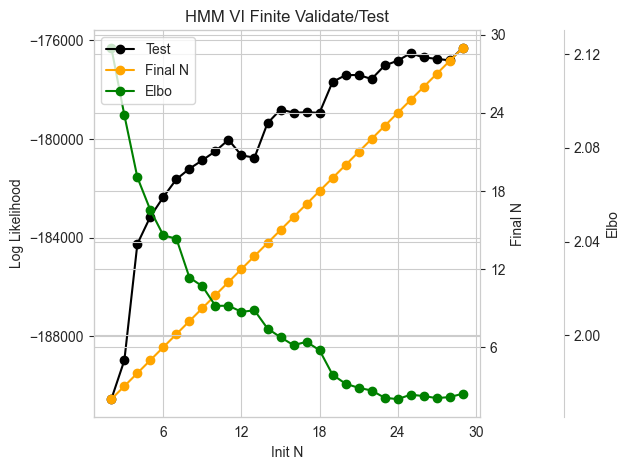

In [21]:
components_results = results_vi_finite['components']
color1, color2, color3 = plt.cm.viridis([0, .5, .9])

avg_val_ll = [components_results[some_key]['avg_val'] for some_key in components_results]
test_ll = [components_results[some_key]['test'] for some_key in components_results]
final_components = [components_results[some_key]['final_components_mean'] for some_key in components_results]
elbo = [components_results[some_key]['elbo'] for some_key in components_results]

fig, ax = plt.subplots()

# ax.plot(ns, avg_val_ll, color='blue', label='Val', marker='o')
ax.plot(ns, test_ll, color='black', label='Test', marker='o')

ax2 = ax.twinx()
ax2.plot(ns, final_components, color='orange', label='Final N', marker='o')
# ax2.set_ylim(0,15)
# ax2.set_yticks(np.arange(0,15,1))

ax3 = ax.twinx()
ax3.plot(ns, elbo, label='Elbo', marker='o', color='green')
ax3.set_ylabel("Elbo")
ax3.spines['right'].set_position(('outward', 60))
# ax3.set_ylim(-0.1,0.15)

ax.legend(handles=ax.lines + ax2.lines + ax3.lines)
ax.set_title("HMM VI Finite Validate/Test")
ax.set_ylabel("Log Likelihood")
ax2.set_ylabel("Final N")
ax.set_xlabel("Init N")
all_axes = fig.get_axes()
for axis in all_axes:
    legend = axis.get_legend()
    if legend is not None:
        legend.remove()
        all_axes[-1].add_artist(legend)
fig.tight_layout()
plt.show()

In [22]:
# run VI on infinite HMM, plot ELBO
K = 20            # Number of clusters/states
gamma = 10
transAlpha = 0.5  # trans-level Dirichlet concentration parameter
startAlpha = 2      # top-level Dirichlet concentration parameter
sF = 1.0          # Set observation model prior so E[covariance] = identity
ECovMat = 'eye'
n_inits_v2 = np.arange(0,1,1)
ns = np.arange(2,30,1)
convergeThr = 0.1 # 0.0001
nLap = 50 # 100

In [23]:

start_outer = time.time()
results_vi_inf = {}
results_per_component = {}
for n in ns:
    print('calculating for n: ', n)
    start_inner = time.time()
    total_inits = 0
    lls = []
    models = []
    aic = []
    bic = []
    models_bnpy = []
    elbos = []
    final_components = []

    for cv_index in range(len(hmm_data['train_data'])):
        curr_train = hmm_data['train_data'][cv_index]
        curr_train_GroupXData = get_GroupXData_from_list(curr_train)
        curr_val = hmm_data['val_data'][cv_index]

        for i in n_inits_v2:
            total_inits += 1

            # train and test
            hmmdiag_trained_model, hmmdiag_info_dict = bnpy.run(
            curr_train_GroupXData, 'HDPHMM', 'DiagGauss', 'memoVB',
            output_path='/tmp/mocap6/showcase-K=20-model=HDPHMM+DiagGauss-ECovMat=1*eye/',
            nLap=nLap, nTask=1, nBatch=1, convergeThr=convergeThr, startAlpha=startAlpha,
            transAlpha=transAlpha, gamma=gamma, hmmKappa=10, sF=sF, ECovMat=ECovMat,
            K=n, initname='randexamples')
            elbo = hmmdiag_info_dict['loss']
            curr_hmm = get_hmm_learn_from_bnpy(hmmdiag_trained_model)
            ll = curr_hmm.score(np.concatenate(curr_val))

            # append
            lls.append(ll)
            models.append(curr_hmm)
            aic.append(curr_hmm.aic(np.concatenate(curr_train + curr_val)))
            bic.append(curr_hmm.bic(np.concatenate(curr_train + curr_val)))
            models_bnpy.append([hmmdiag_trained_model, hmmdiag_info_dict])
            elbos.append(elbo)

            # final components from A matrix
            diag_alpha = np.diag(curr_hmm.transmat_)
            # min_diag_alpha = np.min(diag_alpha)
            count_min_diag_alpha = len(np.where(np.isclose(diag_alpha,1.0))[0])
            n_comps = len(diag_alpha)
            if count_min_diag_alpha > 1:
                n_comps = len(diag_alpha) - count_min_diag_alpha
            final_components.append(n_comps)

    best_model = np.argmax(lls)
    average_score = np.mean(lls)
    end_inner = time.time()
    results_per_component[n] = {
        'lls': lls,
        'models': models,
        'bic': np.mean(bic),
        'aic': np.mean(aic),
        'models_bnpy': models_bnpy,
        'time': (end_inner - start_inner),
        'test': models[best_model].score(np.concatenate(curr_test)),
        'avg_val': average_score,
        'elbo': np.mean(elbos),
        'final_components': final_components,
        'final_components_mean': np.mean(final_components)
    }
    print('final_components_mean', np.mean(final_components))

end_outer = time.time()
results_vi_inf['total_time'] = end_outer - start_outer
results_vi_inf['components'] = results_per_component
results_vi_inf['total_its'] = len(hmm_data['train_data']) * len(n_inits_v2)
results_vi_inf['component_list'] = ns

calculating for n:  2
Dataset Summary:
GroupXData
  total size: 12 units
  batch size: 12 units
  num. batches: 1
Allocation Model:  None
Obs. Data  Model:  Gaussian with diagonal covariance.
Obs. Data  Prior:  independent Gauss-Wishart prior on each dimension
  Wishart params 
    nu = 67  ...
  beta = [ 65  65]  ...
  Expectations
  E[  mean[k]] = 
  [ 0  0] ...
  E[ covar[k]] = 
  [[1. 0.]
   [0. 1.]] ...
Initialization:
  initname = randexamples
  K = 2 (number of clusters)
  seed = 1607680
  elapsed_time: 0.0 sec
Learn Alg: memoVB | task  1/1 | alg. seed: 1607680 | data order seed: 8541952
task_output_path: /tmp/mocap6/showcase-K=20-model=HDPHMM+DiagGauss-ECovMat=1*eye/1
    1.000/50 after      0 sec. |   1686.7 MiB | K    2 | loss  2.159033769e+00 |  
    2.000/50 after      0 sec. |   1686.8 MiB | K    2 | loss  2.133523490e+00 | Ndiff  252.028 
    3.000/50 after      0 sec. |   1686.8 MiB | K    2 | loss  2.123053807e+00 | Ndiff   86.806 
    4.000/50 after      0 sec. |   168

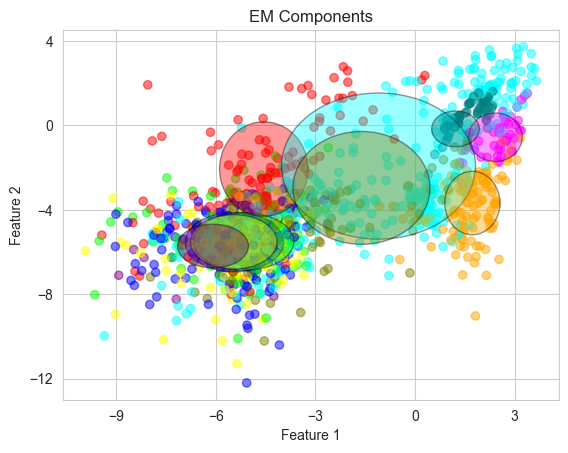

score:  -179102.0733944728


In [25]:
from bnpy import plot_hmm
reload(plot_hmm)
hmm_temp = results_vi_inf['components'][11]['models'][0]
plot_hmm.plot_hmm_data(np.concatenate(curr_test), hmm_temp.predict(np.concatenate(curr_test)), hmm_temp.n_components, hmm_temp.means_, hmm_temp.covars_, feature_a=8, feature_b=9, legend=False, title='EM Components')
print('score: ', hmm_temp.score(np.concatenate(curr_test)))

In [44]:
output = open('results_vi_infinite_hb' + ".pkl", "wb")
pickle.dump(results_vi_inf, output)
output.close()

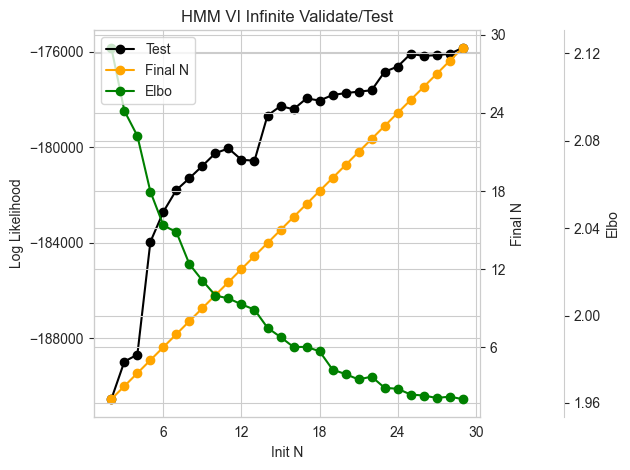

In [26]:
components_results = results_vi_inf['components']
color1, color2, color3 = plt.cm.viridis([0, .5, .9])

avg_val_ll = [components_results[some_key]['avg_val'] for some_key in components_results]
test_ll = [components_results[some_key]['test'] for some_key in components_results]
final_components = [components_results[some_key]['final_components_mean'] for some_key in components_results]
elbo = [components_results[some_key]['elbo'] for some_key in components_results]

fig, ax = plt.subplots()

# ax.plot(ns, avg_val_ll, color='blue', label='Val', marker='o')
ax.plot(ns, test_ll, color='black', label='Test', marker='o')

ax2 = ax.twinx()
ax2.plot(ns, final_components, color='orange', label='Final N', marker='o')
# ax2.set_ylim(0,15)
# ax2.set_yticks(np.arange(0,15,1))

ax3 = ax.twinx()
ax3.plot(ns, elbo, label='Elbo', marker='o', color='green')
ax3.set_ylabel("Elbo")
ax3.spines['right'].set_position(('outward', 60))
# ax3.set_ylim(-0.1,0.15)

ax.legend(handles=ax.lines + ax2.lines + ax3.lines)
ax.set_title("HMM VI Infinite Validate/Test")
ax.set_ylabel("Log Likelihood")
ax2.set_ylabel("Final N")
ax.set_xlabel("Init N")
all_axes = fig.get_axes()
for axis in all_axes:
    legend = axis.get_legend()
    if legend is not None:
        legend.remove()
        all_axes[-1].add_artist(legend)
fig.tight_layout()
plt.show()


In [18]:
## why is vi so much better than EM ?
from bnpy import plot_hmm
reload(plot_hmm)

<module 'bnpy.plot_hmm' from '/Users/david/Documents/mastersCode/bnpy/bnpy/bnpy/plot_hmm.py'>

In [27]:
print('max EM test value: ', np.max([results_em['components'][some_key]['test'] for some_key in results_em['components']]), (np.argmax([results_em['components'][some_key]['test'] for some_key in results_em['components']])), results_em['total_time'])
print('max EM bnpy test value: ', np.max([results_em_bnpy['components'][some_key]['test'] for some_key in results_em_bnpy['components']]), (np.argmax([results_em_bnpy['components'][some_key]['test'] for some_key in results_em_bnpy['components']])), results_em_bnpy['total_time'])
print('max VI finite test value: ', np.max([results_vi_finite['components'][some_key]['test'] for some_key in results_vi_finite['components']]),np.argmax([results_vi_finite['components'][some_key]['test'] for some_key in results_vi_finite['components']]), results_vi_finite['total_time'])
print('max VI infinite test value: ', np.max([results_vi_inf['components'][some_key]['test'] for some_key in results_vi_inf['components']]), np.argmax([results_vi_inf['components'][some_key]['test'] for some_key in results_vi_inf['components']]), results_vi_inf['total_time'])

max EM test value:  -173094.2929872187 22 20.10111403465271
max EM bnpy test value:  -173145.66309532654 24 502.8025629520416
max VI finite test value:  -176300.83193360257 27 624.7332811355591
max VI infinite test value:  -175829.68698581654 27 204.37282395362854


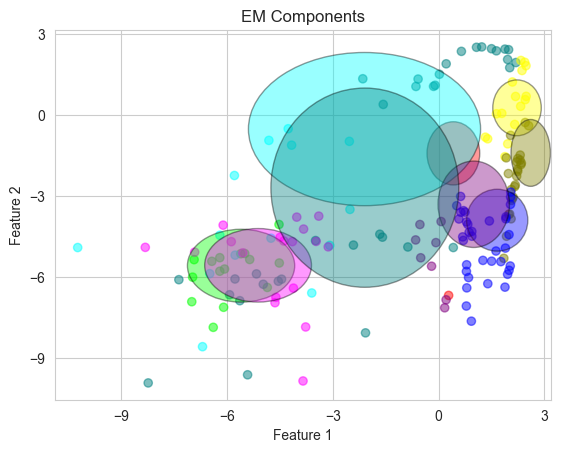

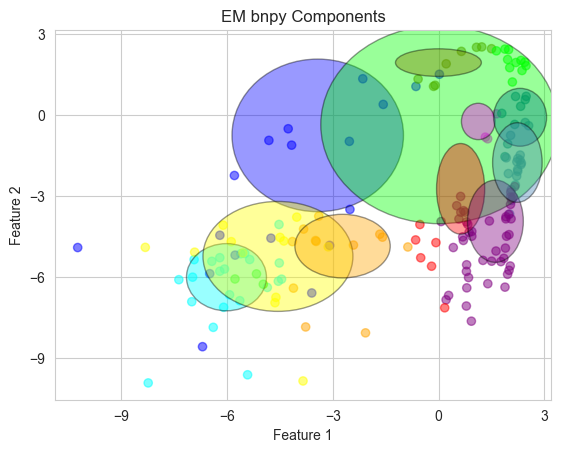

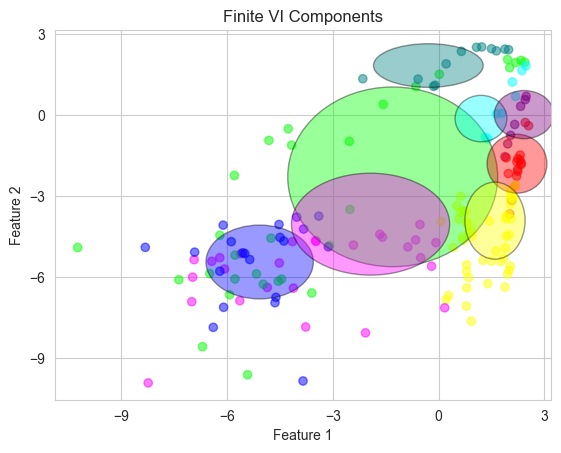

22


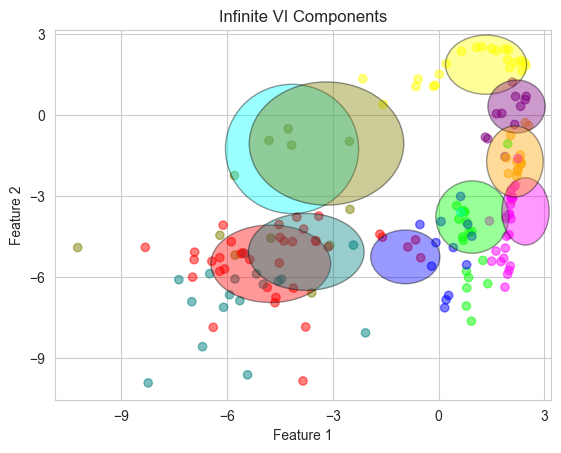

In [32]:

data_temp = hmm_data['train_data'][0][0]
feature_a = 8
feature_b = 9

temp = np.argmax([results_em['components'][some_key]['test'] for some_key in results_em['components']])
hmm_temp = results_em['components'][16+2]['models'][1]
plot_hmm.plot_hmm_data(data_temp, hmm_temp.predict(data_temp), hmm_temp.n_components, hmm_temp.means_, hmm_temp.covars_, feature_a=feature_a, feature_b=feature_b, legend=False, title='EM Components')

temp = np.argmax([results_em_bnpy['components'][some_key]['test'] for some_key in results_em_bnpy['components']])
hmm_temp = results_em_bnpy['components'][16+2]['models'][1]
plot_hmm.plot_hmm_data(data_temp, hmm_temp.predict(data_temp), hmm_temp.n_components, hmm_temp.means_, hmm_temp.covars_, feature_a=feature_a, feature_b=feature_b, legend=False, title='EM bnpy Components')

temp = np.argmax([results_vi_finite['components'][some_key]['test'] for some_key in results_em['components']])
hmm_temp = results_vi_finite['components'][13+2]['models'][0]
plot_hmm.plot_hmm_data(data_temp, hmm_temp.predict(data_temp), hmm_temp.n_components, hmm_temp.means_, hmm_temp.covars_, feature_a=feature_a, feature_b=feature_b, percent=1, legend=False, title='Finite VI Components')

temp = np.argmax([results_vi_inf['components'][some_key]['test'] for some_key in results_em['components']])
print(temp)
hmm_temp = results_vi_inf['components'][17+2]['models'][1]
plot_hmm.plot_hmm_data(data_temp, hmm_temp.predict(data_temp), hmm_temp.n_components, hmm_temp.means_, hmm_temp.covars_, feature_a=feature_a, feature_b=feature_b, percent=1, legend=False, title='Infinite VI Components')


In [47]:
## infinite with merge moves

goodelbopairs_merge_kwargs = dict(
    m_startLap = 10,
    # Set limits to number of merges attempted each lap.
    # This value specifies max number of tries for each cluster
    m_maxNumPairsContainingComp = 5,
    # Set "reactivation" limits
    # So that each cluster is eligible again after 10 passes thru dataset
    # Or when it's size changes by 400%
    m_nLapToReactivate = 10,
    m_minPercChangeInNumAtomsToReactivate = 400 * 0.01,
    # Specify how to rank pairs (determines order in which merges are tried)
    # 'obsmodel_elbo' means rank pairs by improvement to observation model ELBO
    m_pair_ranking_procedure = 'obsmodel_elbo',
    m_pair_ranking_direction = 'descending',
    )

init_kwargs = dict(
    K=30,
    initname='randexamples',
    )

alg_kwargs = dict(
    nLap=100,
    nTask=1, nBatch=1, convergeThr=0.0001,
    )

hdphmm_kwargs = dict(
    startAlpha = 2.0,       # top-level Dirichlet concentration parameter
    transAlpha = 0.5,  # trans-level Dirichlet concentration parameter
    hmmKappa = 10,
    )

gauss_kwargs = dict(
    sF = 1,          # Set prior so E[covariance] = identity
    ECovMat = 'eye',
    )

# run VI on infinite HMM

aic_inf_merge = []
bic_inf_merge = []
lls_inf_merge = []
lls_elbo_inf_merge = []

best_ll = None
best_model = None
best_model_hmmlearn = None
best_elbo = None
best_model_info = None
all_elbos = []
all_ks = []
# print('calculating for n: ', n)
for cv_index in range(len(hmm_data['train_data'])):
    curr_train = hmm_data['train_data'][cv_index]
    curr_train_GroupXData = get_GroupXData_from_list(curr_train)
    curr_val = hmm_data['val_data'][cv_index]
    for i in [1]:
        goodelbopairs_trained_model, goodelbopairs_info_dict = bnpy.run(
            curr_train_GroupXData, 'HDPHMM', 'DiagGauss', 'memoVB',
            output_path='/tmp/mocap6/trymerge-K=20-model=HDPHMM+DiagGauss-ECovMat=1*eye-merge_strategy=good_elbo_pairs/',
            moves='merge,shuffle',
            **dict(
                sum(map(list,   [alg_kwargs.items(),
                                init_kwargs.items(),
                                hdphmm_kwargs.items(),
                                gauss_kwargs.items(),
                                goodelbopairs_merge_kwargs.items()]),[])))

        elbo = goodelbopairs_info_dict['loss']
        # all_elbos.append(elbo)
        # all_ks.append(goodelbopairs_trained_model.obsModel.K)
        curr_hmm = get_hmm_learn_from_bnpy(goodelbopairs_trained_model)
        score = curr_hmm.score(np.concatenate(curr_val))
        if not best_elbo or elbo < best_elbo:
            # best_ll = score
            best_model = goodelbopairs_trained_model
            best_model_info = goodelbopairs_info_dict
            best_model_hmmlearn = curr_hmm
# aic_inf_merge.append(best_model.aic(np.concatenate(curr_test)))
# bic_inf_merge.append(best_model.bic(np.concatenate(curr_test)))
# lls_inf_merge.append(best_model.score(np.concatenate(curr_test)))
# lls_elbo_inf_merge.append(best_elbo)


Dataset Summary:
GroupXData
  total size: 12 units
  batch size: 12 units
  num. batches: 1
Allocation Model:  None
Obs. Data  Model:  Gaussian with diagonal covariance.
Obs. Data  Prior:  independent Gauss-Wishart prior on each dimension
  Wishart params 
    nu = 67  ...
  beta = [ 65  65]  ...
  Expectations
  E[  mean[k]] = 
  [ 0  0] ...
  E[ covar[k]] = 
  [[1. 0.]
   [0. 1.]] ...
Initialization:
  initname = randexamples
  K = 30 (number of clusters)
  seed = 1607680
  elapsed_time: 0.0 sec
Learn Alg: memoVB | task  1/1 | alg. seed: 1607680 | data order seed: 8541952
task_output_path: /tmp/mocap6/trymerge-K=20-model=HDPHMM+DiagGauss-ECovMat=1*eye-merge_strategy=good_elbo_pairs/1
MERGE @ lap 1.00: Disabled. Cannot plan merge on first lap. Need valid SS that represent whole dataset.
    1.000/100 after      0 sec. |   1089.8 MiB | K   30 | loss  1.269190620e+00 |  
MERGE @ lap 2.00: Disabled. Waiting for lap >= 10 (--m_startLap).
    2.000/100 after      0 sec. |   1089.8 MiB | K 

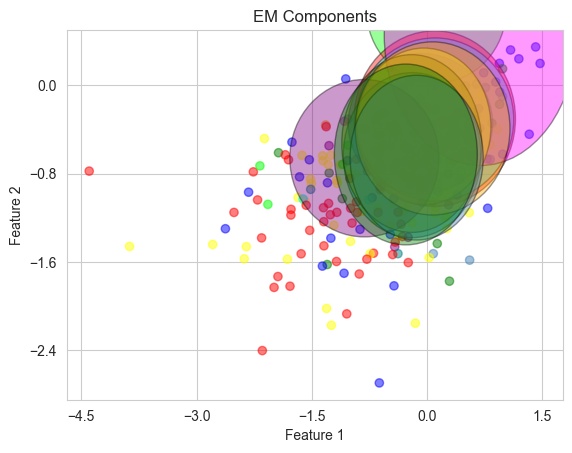

In [46]:
data_temp = hmm_data['train_data'][0][0]
best_model_hmmlearn.score(data_temp)
plot_hmm.plot_hmm_data(data_temp, best_model_hmmlearn.predict(data_temp), best_model_hmmlearn.n_components, best_model_hmmlearn.means_, best_model_hmmlearn.covars_, feature_a=5, feature_b=6, legend=False, title='EM Components')

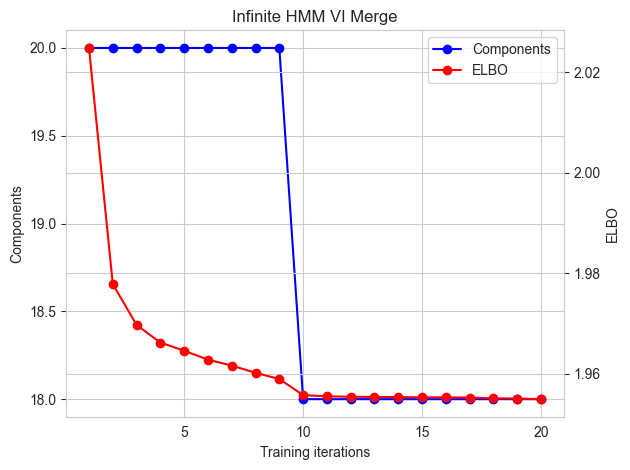

In [24]:
# plt.plot(np.arange(len(all_ks)), all_ks)
its_cutoff = 20
k_history = best_model_info['K_history'][:its_cutoff]
loss_history = best_model_info['loss_history'][:its_cutoff]
laps = best_model_info['lap_history'][:its_cutoff]
# run VI on infinite HMM, plot ELBO and amount of components,

fig, ax = plt.subplots()
# ln1 = ax.plot(ns, aic_inf, label="AIC", color="blue", marker="o")
# # ln12 = ax.plot(ns, aic_em, label="AIC", color="darkblue", marker="o")
# ln2 = ax.plot(ns, bic_inf, label="BIC", color="green", marker="o")
# ln22 = ax.plot(ns, bic_em, label="BIC", color="darkgreen", marker="o")
ax.plot(laps, k_history, label="Components", color="blue", marker="o")
ax2 = ax.twinx()
ax2.plot(laps, loss_history, label="ELBO", color="red", marker="o")
# # ln5 = ax2.plot(ns, lls_em, label="LL", color="pink", marker="o")
# ax3 = ax.twinx()
# ln4 = ax3.plot(ns, lls_elbo_inf, label="elbo", color="red", marker="o")

ax.legend(handles=ax.lines + ax2.lines)
ax.set_title("Infinite HMM VI Merge")
ax.set_ylabel("Components")
ax2.set_ylabel("ELBO")
ax.set_xlabel("Training iterations")
all_axes = fig.get_axes()
for axis in all_axes:
    legend = axis.get_legend()
    if legend is not None:
        legend.remove()
        all_axes[-1].add_artist(legend)
fig.tight_layout()
plt.show()